## SGDRegressor

In [ ]:
sdgr = SGDRegressor(max_iter=200, tol=0.00001)

y_living_meters = data_reg[(data_reg['living_meters'].notnull()) & (data_reg['kitchen_meters'].notnull())]['living_meters']
X_living_meters = data_reg[(data_reg['living_meters'].notnull()) & (data_reg['kitchen_meters'].notnull())].iloc[:,[1,3]]

sdgr.fit(X_living_meters.values,y_living_meters.values)

y_pred = sdgr.predict(X_living_meters.values)
resid = y_living_meters - y_pred
# тест на автокорреляцию остатков
sm.stats.stattools.durbin_watson(resid)

In [ ]:
# гомоскедастичность остатков
for i in range(0,2):
    plt.figure(figsize= (3,3))
    plt.scatter(X_living_meters.iloc[:,i].values, resid.values, alpha=0.5)
    plt.xlabel(f'X_living_meters{i+1}')
    plt.ylabel('Остатки')
    plt.title(f'График остатков для X_living_meters{i+1}')
plt.show()

In [ ]:
mae = mean_absolute_error(y_living_meters.values, y_pred)
mse = mean_squared_error(y_living_meters.values, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_living_meters.values, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

In [ ]:
# распределение ошибок
plt.figure(figsize= (3,3))
plt.hist(resid,bins = 20);

## Градиентный бустинг

In [ ]:
y = data[(data['kitchen_meters'].notnull())]['kitchen_meters'].copy()
X = data[(data['kitchen_meters'].notnull())].loc[:,['total_meters','price','year_of_construction','living_meters','city']].copy()
label_encoder = LabelEncoder()
for item in ['city']:
    X[item] = label_encoder.fit_transform(X[item])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
i = 1
n = X_train.shape[0]
print(n)
while i < 3:
    n //=3
    print(n)
    i+=1
print(f'нужно использовать {n} с factor = 3')

model = GradientBoostingRegressor()
params = {'loss':['squared_error', 'absolute_error'],
          'max_features':[1.0],
          'max_depth':np.logspace(1.3, 2.2, num=4, endpoint=True, base=5, dtype=int).tolist(),
         'learning_rate': [0.005,0.01,0.02],
         'n_estimators':np.logspace(2, 3, num=4, endpoint=True, base=5, dtype=int).tolist(),
         'min_samples_split':np.logspace(0.65, 3, num=4, endpoint=True, base=5, dtype=int).tolist()}
halving_search = HalvingGridSearchCV(estimator=model,
                           param_grid=params,
                           cv=5,
                           aggressive_elimination=True,
                           min_resources= n,
                           factor= 3) # n_jobs = -1
halving_search.fit(X_train, y_train)

print(halving_search.best_params_)
y_pred = halving_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

## AdaBoost

In [ ]:
y = data[(data['kitchen_meters'].notnull())]['kitchen_meters'].copy()
X = data[(data['kitchen_meters'].notnull())].loc[:,['total_meters','price','year_of_construction','living_meters','city']].copy()
label_encoder = LabelEncoder()
for item in ['city']:
    X[item] = label_encoder.fit_transform(X[item])
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

i = 1
n = X_train.shape[0]
print(n)
while i < 3:
    n //=3
    print(n)
    i+=1
print(f'нужно использовать {n} с factor = 3')

DTR = DecisionTreeRegressor(max_depth=5)
KNN = KNeighborsRegressor(n_neighbors=3)
LR = LinearRegression()
LASSO = Lasso(alpha=0.1)
params = {'estimator':[DTR,KNN,LR,LASSO], 
          'n_estimators':np.logspace(3.1, 3.5, num=3, endpoint=True, base=5, dtype=int).tolist(), 
          'learning_rate':[0.01, 0.1, 0.5], 
          'loss':['linear','square','exponential']}

ABC = AdaBoostRegressor(random_state=42)

halving_search = HalvingGridSearchCV(estimator=ABC,
                           param_grid=params,
                           cv=5,
                           aggressive_elimination=True,
                           min_resources= n,
                           factor= 3)
halving_search.fit(X_train, y_train)

print(halving_search.best_params_)

y_pred = halving_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

## Пробовал заполнить с помощью полинома living_meters(не учел, что нужно проверять на тестовой выборке, которую модель никогда не видела)

In [ ]:
y_living_meters = data_reg[(data_reg['living_meters'].notnull())]['living_meters']
X_living_meters = data_reg[(data_reg['living_meters'].notnull())].iloc[:,[1,2,4]]

poly = PolynomialFeatures(degree=2)
X_living_meters = poly.fit_transform(X_living_meters)
lr = LinearRegression(fit_intercept=True)

lr.fit(X_living_meters,y_living_meters)
y_pred = lr.predict(X_living_meters)
resid = y_living_meters - y_pred

In [ ]:
sm.stats.stattools.durbin_watson(resid)

In [ ]:
# распределение ошибок
plt.figure(figsize= (3,3))
plt.hist(resid,bins = 30);

In [ ]:
mae = mean_absolute_error(y_living_meters.values, y_pred) 
# mae насколько в среднем по модулю отличаются предсказанные от истинных в оригинальных единицах измерения
mse = mean_squared_error(y_living_meters.values, y_pred) # mse и rmse сильнее подвержены влиянию выбросов, чем mae
rmse = np.sqrt(mse)
r2 = r2_score(y_living_meters.values, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

In [ ]:
plt.figure(figsize=(5, 5))
sns.histplot(y_pred,bins = 75)
sns.histplot(y_living_meters,bins = 75);

## Заполнение пропусков методом случайного леса
## residential_complex

In [ ]:
X = data.loc[~data.residential_complex.isna(), ['author','author_type','city','floor', 'floors_count', 'rooms_count',
       'total_meters', 'price_per_m2', 'price', 'year_of_construction','living_meters']]

y = data.loc[~data.residential_complex.isna(),'residential_complex']
# это нужно предсказать
x_nan_residential_complex = data.loc[data.residential_complex.isna(), ['author','author_type','city','floor', 'floors_count', 'rooms_count',
       'total_meters', 'price_per_m2', 'price', 'year_of_construction','living_meters']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_test,y_test нужны для проверки качества

In [ ]:
classes_less_than_5 = y_train.value_counts()[y_train.value_counts() <5].index
sample_strategy = {item: 5 for item in classes_less_than_5}

ROS = RandomOverSampler(sampling_strategy = sample_strategy)
x_train_resampled, y_train_resampled  = ROS.fit_resample(X_train,y_train)

In [ ]:
label_encoder = LabelEncoder()
for item in ['author','author_type','city','year_of_construction']:
    X_test[item] = label_encoder.fit_transform(X_test[item])
    x_nan_residential_complex[item] = label_encoder.fit_transform(x_nan_residential_complex[item])
    x_train_resampled[item] = label_encoder.fit_transform(x_train_resampled[item])

## Подбор оптимального min_resources

In [ ]:
i = 1
n_residential_complex = x_train_resampled.shape[0]
print(n_residential_complex)
while i < 3:
    n_residential_complex //=3
    print(n_residential_complex)
    i+=1
print(f'нужно использовать {n_residential_complex} с factor = 3')

## Продолжение заполнения пропусков residential_complex

In [ ]:
clf_rf = RandomForestClassifier(random_state=42)

params = {'criterion':['entropy','gini'],
          'n_estimators':np.logspace(1.5, 2.7, num=5, endpoint=True, base=5, dtype=int).tolist(), 
          'max_depth':range(5,15),
          'min_samples_split':np.logspace(1, 2, num=5, endpoint=True, base=5, dtype=int).tolist(),
          'min_samples_leaf':np.logspace(1, 2, num=4, endpoint=True, base=5, dtype=int).tolist(),
          'max_features': ['sqrt','log2']}

halving_search = HalvingGridSearchCV(estimator=clf_rf,
                           param_grid=params,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=42),
                           aggressive_elimination=True,
                           min_resources= n_residential_complex,
                           factor= 3,          
                           n_jobs = -1)
halving_search.fit(x_train_resampled,y_train_resampled)

In [ ]:
print(halving_search.best_params_)
print(halving_search.best_score_)
importances = pd.Series((halving_search.best_estimator_.feature_importances_),index = x_train_resampled.columns)
importances

In [ ]:
residential_complex_pred = halving_search.predict(x_test_residential_complex)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, halving_search.predict(X_test),zero_division = 1)
print(precision.mean())
print(recall.mean())
print(f1_score(y_test, halving_search.predict(X_test), average='macro'))

In [ ]:
data.loc[data.residential_complex.isna(),'residential_complex'] = residential_complex_pred

## Заготовка для построения модели по уже найденным оптимальным параметрам residential_complex

In [ ]:
# clf_rf = RandomForestClassifier(criterion='entropy',
#                                 max_depth= 10,
#                                 max_features='sqrt',
#                                 min_samples_leaf=2,
#                                 min_samples_split=5,
#                                 n_estimators=50,
#                                 random_state=42)
# clf_rf.fit(x_train_resampled,y_train_resampled)
# residential_complex_nonan = clf_rf.predict(x_test)

In [ ]:
# residential_complex_nonan.shape

In [ ]:
# residential_complex_nonan = pd.Series(residential_complex_pred, 
#                                       index = data.loc[data.residential_complex.isna(),'residential_complex'].index)
# residential_complex_nonan.head()

In [ ]:
# data.loc[data.residential_complex.isna(),'residential_complex'] = residential_complex_nonan

### Подбор оптимального min_resources и параметров RandomForestClassifier для заполнения street

In [ ]:
# i = 1
# n_street = X_train.shape[0]
# print(n_street)
# while i < 3:
#     n_street //=3
#     print(n_street)
#     i+=1
# print(f'нужно использовать {n_street} с factor = 3')
# clf_rf_street = RandomForestClassifier(random_state=42)

# params_street = {'criterion':['entropy','gini'],
#           'n_estimators':np.logspace(1.5, 2.7, num=5, endpoint=True, base=5, dtype=int).tolist(), 
#           'max_depth':range(5,15),
#           'min_samples_split':np.logspace(1, 2, num=5, endpoint=True, base=5, dtype=int).tolist(),
#           'min_samples_leaf':np.logspace(1, 2, num=4, endpoint=True, base=5, dtype=int).tolist(),
#           'max_features': ['sqrt','log2']}

# halving_search_street = HalvingGridSearchCV(estimator = clf_rf_street,
#                            param_grid = params_street,
#                            aggressive_elimination=True,
#                            cv = 5, #StratifiedKFold(n_splits = 5, shuffle = True),
#                            min_resources= n_street,
#                            factor= 3,
#                            n_jobs = -1)

# halving_search_street.fit(X_train_resampled,y_train_resampled)

In [ ]:
# print(halving_search_street.best_params_)
# print(halving_search_street.best_score_)

In [ ]:
# y_test_pred = halving_search_street.predict(X_test)
# precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred,zero_division = 1)
# print(precision.mean())
# print(recall.mean())
# print(fscore.mean())
# #print(support)

## GradientBoostingClassifier(очень долгий) для street

In [ ]:
#  GBC = GradientBoostingClassifier(random_state=42,
#                             min_samples_split=2,
#                             max_depth = 3,
#                             min_samples_leaf=2,
#                             n_estimators=100,
#                             learning_rate=0.1,
#                             verbose=1,
#                             loss='deviance')
# GBC.fit(X_train, y_train)
# y_pred = GBC.predict(X_test)
# precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 1)
# print(precision.mean())
# print(recall.mean())
# print(fscore.mean())

## OneVsOneClassifier

In [ ]:
# очень долгий
DTC = DecisionTreeClassifier(max_depth = 10)
OneVSOne = OneVsOneClassifier(DTC)
OneVSOne.fit(X_train,y_train)

y_pred = OneVSOne.predict(X_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 1)
print(precision.mean())
print(recall.mean())
print(fscore.mean())

## OneVsRestClassifier

In [ ]:
OneVSRest = OneVsRestClassifier(LinearSVC(dual=False)) # SVC()
OneVSRest.fit(X_train,y_train)

y_pred = OneVSRest.predict(X_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 1)
print(precision.mean())
print(recall.mean())
print(fscore.mean())

## RandomForest(street)

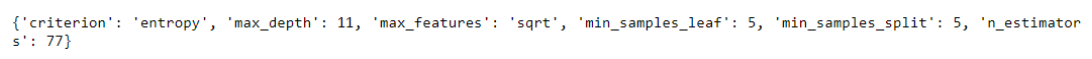

In [ ]:
clf_rf = RandomForestClassifier(criterion='entropy',
                                max_depth= 11,
                                max_features='sqrt',
                                min_samples_leaf=5,
                                min_samples_split=5,
                                n_estimators=207,
                                random_state=42)

clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 1)
print(precision.mean())
print(recall.mean())
print(fscore.mean())

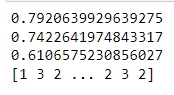

## BalancedRandomForestClassifier

In [ ]:
BRFC = BalancedRandomForestClassifier(criterion='entropy',
                                      n_estimators=170,
                                      max_depth=12,
                                      min_samples_split=5,
                                      min_samples_leaf=10,
                                      verbose=1,
                                      n_jobs = 2,
                                      random_state=42)
BRFC.fit(X_train,y_train)

y_pred = BRFC.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 1)
print(precision.mean())
print(recall.mean())
print(fscore.mean())

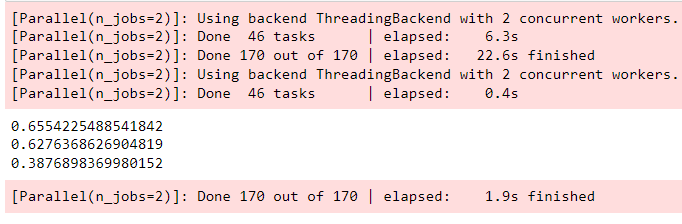

## AdaBoostClassifier (SVC)

In [ ]:
SVC = SVC(random_state=42, probability = True, kernel = 'linear',cache_size=300)
ABC = AdaBoostClassifier(random_state=42,
                            estimator=SVC, 
                            n_estimators=50,
                            learning_rate=0.1, 
                            algorithm='SAMME.R')
ABC.fit(X_train, y_train)
y_pred = ABC.predict(X_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 'warn')
print(precision.mean())
print(recall.mean())
print(fscore.mean())

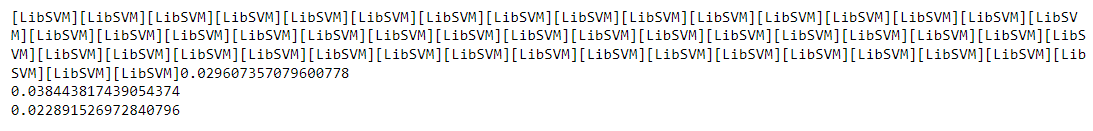

## начальный этап строительства дэшборда

In [ ]:
# конструктор dash, отвечает за инициализацию приложения
app = Dash(__name__)
link = 'https://docs.google.com/spreadsheets/d/e/' \
       '2PACX-1vQxxmZm6YG54VucQ9yRgWFQXtOI-RFJ5-sOLT93LpaYGYc-vabL9LOzzkRXX-LmSROTA7hOL1C327nZ/pub?gid=213261502&single=true&output=csv'
df = pd.read_csv(link)

# Макет приложения представляет компоненты приложения, которые будут отображаться в веб-браузере, обычно содержащиеся
# в файле html.Div
app.layout = html.Div([
    html.Div(children='Первый трай'),
    html.Hr(),
    dcc.RadioItems(options=['Moskva', 'Sankt-Peterburg'], value='Moskva', id='controls-and-radio-item'),
    dcc.Graph(figure={},id='controls-and-graph')
])